# Explore SDSSRM-XCS Scatter: Jackknifing to assess $M_{\rm{tot}}$-$L_{\rm{X}}$

This section of the project explores potential reasons and diagnostics of galaxy cluster/group scaling relation scatter using the new SDSSRM-XCS relations constructed in this work from the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract).

Here we particularly focus on using the common 'jackknife' re-sampling technique in an attempt to identify particular clusters that are the dominant cause of a large scatter measurement for some of our more important scaling relations. Such data points (if they are present) may be genuine measurement outliers, caused by some fitting failure or analysis problem for an individual cluster in the first paper of this series. They may also be clusters that _are_ intrinsically more scattered. 

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* **<span style="color:red">.......</span>**

## Import Statements 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import pickle
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo, m_norm, lx_norm, leave_one_jackknife

import xga
from xga.relations.fit import scaling_relation_lira

# Setting up this constant that controls the confidence intervals calculated for the scatter change
#  distributions - makes it much easier to change the exact value later if we need too. This is 
#  what is going to be used to define the scatter-dominating clusters.
CONF_PERC = 90

## Loading data files and relations

We load the 'base' SDSSRM-XCS sample file, containing some basic information about galaxy cluster names, positions, and redshifts. We also load the SDSSRM-XCS cluster property results files from the first paper of this series. 

The scaling relations which we are performing our bootstrapping scatter assessment on are also loaded in here.

### SDSSRM-XCS base sample

In [2]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,True,False
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,True,False
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,True,False
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,False,True
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,True,False
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,True,False


Calculating E(z) values for these clusters:

In [3]:
sdssxcs_base['E'] = xcs_cosmo.efunc(sdssxcs_base['z'].values)

### SDSSRM-XCS $T_{\rm{X}}$ and $L_{\rm{X}}$

In [4]:
sdssxcs_txlx = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_txlx_v1.0.0.csv")
sdssxcs_txlx.head(6)

,name,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lxbol_500,Lxbol_500-,Lxbol_500+,Tx_2500,Tx_2500-,Tx_2500+,Lx52_2500,Lx52_2500-,Lx52_2500+,Lxbol_2500,Lxbol_2500-,Lxbol_2500+,Tx_500ce,Tx_500ce-,Tx_500ce+,Lx52_500ce,Lx52_500ce-,Lx52_500ce+,Lxbol_500ce,Lxbol_500ce-,Lxbol_500ce+
0,SDSSXCS-124,6.92000,0.116389,0.111642,5.310408e+44,2.494586e+42,3.193270e+42,2.039754e+45,2.082091e+43,1.712354e+43,7.08946,0.097823,0.097929,4.008461e+44,2.163312e+42,1.887667e+42,1.557705e+45,1.278003e+43,1.166420e+43,6.78098,0.134306,0.158223,3.684827e+44,2.702225e+42,2.572964e+42,1.401501e+45,1.425781e+43,1.280567e+43
1,SDSSXCS-2789,4.54033,0.073600,0.074023,1.029575e+44,5.149604e+41,6.858712e+41,3.213527e+44,3.914562e+42,3.124017e+42,4.44237,0.057404,0.057774,7.125319e+43,4.164749e+41,3.793543e+41,2.201238e+44,1.767406e+42,1.642524e+42,4.65452,0.108600,0.113677,6.943669e+43,6.482835e+41,5.773788e+41,2.192642e+44,2.960496e+42,2.652251e+42
2,SDSSXCS-290,5.31681,0.297854,0.336308,2.856695e+44,5.917234e+42,7.322989e+42,9.632533e+44,4.005991e+43,3.207763e+43,5.41431,0.259989,0.309605,2.033267e+44,4.662931e+42,4.169953e+42,6.920658e+44,2.211700e+43,1.983518e+43,5.44819,0.407899,0.486340,1.972104e+44,6.434636e+42,6.092122e+42,6.734043e+44,3.038773e+43,2.687861e+43
3,SDSSXCS-1018,3.90154,0.143544,0.151498,8.044819e+43,1.441322e+42,9.241468e+41,2.335851e+44,6.385493e+42,4.924304e+42,4.09555,0.108381,0.115430,6.395952e+43,8.467201e+41,7.602523e+41,1.899850e+44,3.436098e+42,3.542190e+42,3.93098,0.207281,0.230478,5.048987e+43,1.253282e+42,1.066663e+42,1.471118e+44,5.740520e+42,4.871391e+42
4,SDSSXCS-134,6.72622,0.116523,0.116565,4.811899e+44,2.458557e+42,3.050440e+42,1.825296e+45,2.068757e+43,1.639058e+43,7.04643,0.104430,0.104760,3.813160e+44,2.170963e+42,1.872005e+42,1.479760e+45,1.263153e+43,1.208755e+43,6.37686,0.135837,0.153820,3.447715e+44,2.713877e+42,2.497416e+42,1.273855e+45,1.415497e+43,1.228583e+43
5,SDSSXCS-119,4.93456,0.400268,0.456173,2.049789e+44,5.182032e+42,6.885075e+42,6.654626e+44,4.141700e+43,3.282061e+43,5.41255,0.397709,0.448294,1.239172e+44,3.785057e+42,3.735144e+42,4.215892e+44,2.155310e+43,1.870703e+43,4.91222,0.432241,0.503558,1.821676e+44,5.522211e+42,5.714386e+42,5.900648e+44,3.822404e+43,2.772960e+43


### SDSSRM-XCS masses

In [5]:
sdssxcs_mass = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_mass_v1.0.0.csv")
sdssxcs_mass.head(6)

,name,Mhy500,Mhy500-,Mhy500+,Mg500,Mg500-,Mg500+,Mhy2500,Mhy2500-,Mhy2500+,Mg2500,Mg2500-,Mg2500+,Mhy500_wraderr,Mhy500_wraderr-,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,7.634491,1.286289,1.029318,0.869914,0.002841,0.005951,2.621329,0.112240,0.137975,0.321744,0.000722,0.000734,7.635562,1.285474,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,7.820374,1.259755,1.447212,0.218603,0.002491,0.002496,1.602926,0.101929,0.109311,0.097414,0.000324,0.000329,7.823912,1.268244,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,2.961604,0.369827,0.382523,0.427969,0.002132,0.002098,1.467429,0.175603,0.290465,0.134154,0.000759,0.000773,2.959792,0.390293,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,5.067958,1.015270,0.969362,0.210208,0.001929,0.001917,1.128892,0.103503,0.149913,0.084371,0.000350,0.000359,5.072697,1.030805,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,6.802619,0.782566,0.772819,0.767290,0.002149,0.002170,3.043225,0.113304,0.110341,0.313945,0.000359,0.000367,6.803511,0.788996,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
5,SDSSXCS-119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combining tables

In [6]:
sdssxcs_samp = pd.merge(sdssxcs_base, sdssxcs_txlx, left_on='name', right_on='name', how='outer')
sdssxcs_samp = pd.merge(sdssxcs_samp, sdssxcs_mass, left_on='name', right_on='name', how='outer')

### $M^{\rm{tot}}_{500}$-$L^{0.5-2.0}_{\rm{X,500}}$

In [7]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-lx/turner2025_mtot500_lx52_500.xgarel', 'rb') as scalo:
    mtot500_lx52_500 = pickle.load(scalo)

### $M^{\rm{tot}}_{500}$-$L^{0.5-2.0}_{\rm{X,500ce}}$

In [8]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-lx/turner2025_mtot500_lx52_500ce.xgarel', 'rb') as scalo:
    mtot500_lx52_500ce = pickle.load(scalo)

### $M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500}}$

In [9]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-lx/turner2025_mtot500_lxbol_500.xgarel', 'rb') as scalo:
    mtot500_lxbol_500 = pickle.load(scalo)

### $M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$

In [10]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-lx/turner2025_mtot500_lxbol_500ce.xgarel', 'rb') as scalo:
    mtot500_lxbol_500ce = pickle.load(scalo)

### $M^{\rm{tot}}_{2500}$-$L^{0.5-2.0}_{\rm{X,2500}}$

In [11]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-lx/turner2025_mtot2500_lx52_2500.xgarel', 'rb') as scalo:
    mtot2500_lx52_2500 = pickle.load(scalo)

### $M^{\rm{tot}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$

In [12]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-lx/turner2025_mtot2500_lxbol_2500.xgarel', 'rb') as scalo:
    mtot2500_lxbol_2500 = pickle.load(scalo)

## Searching for scatter-dominating-clusters using "leave-one-out" jack-knifing

The goal of this notebook is to measure a set of jackknifed scaling relations - this will be achieved by iteratively excluding every single cluster from the sample, one at a time, and fitting those sub-samples in the same was as the original scaling relation  - any large changes in normalisation, slope, or scatter (from the original values measured with whole sample, and from each other) of these relations will help to inform us which clusters (if any) are the dominant source of overall scatter in the relations.

### Setting up input samples

We want to make sure we're only using the clusters which have measurements of the properties we're interested in - **104** of the sample have an $M^{\rm{tot}}_{500}$ measurement, and **91** have a $M^{\rm{tot}}_{2500}$ measurement, for instance. To make this more sample selection more generally useful, as it will be used in other jack-knifing notebooks, we use $M_{\rm{gas}}$ measurements as the test for whether a cluster will be included in a particular sample or not.

#### Clusters with $R_{500}$ properties

In [13]:
# This is the set of SDSSRM-XCS clusters with R500 gas masses - there will not be a hydrostatic mass if there is no gas mass, and
#  we will be using at least one type of mass in all the scaling relations we're assessing
sdssxcs_samp_with_gm500 = sdssxcs_samp[np.isfinite(sdssxcs_samp['Mg500_wraderr'])]

#### Clusters with $R_{2500}$ properties

In [14]:
# This is the set of SDSSRM-XCS clusters with R2500 gas masses - there will not be a hydrostatic mass if there is no gas mass, and
#  we will be using at least one type of mass in all the scaling relations we're assessing
sdssxcs_samp_with_gm2500 = sdssxcs_samp[np.isfinite(sdssxcs_samp['Mg2500_wraderr'])]

### Assessing the $M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500}}$ relation

In [15]:
l1_mtot500_lxbol_500_rels, l1_mtot500_lxbol_500_res = leave_one_jackknife(sdssxcs_samp_with_gm500, mtot500_lxbol_500, 
                                                                          x_cols=['Lxbol_500', 'Lxbol_500-', 'Lxbol_500+'],
                                                                          x_name=r"$L^{\rm{bol}}_{\rm{X,500}}$", 
                                                                          x_norm=lx_norm, dim_hubb_ind=2, 
                                                                          y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$")

Fitting sub-sample scaling relations:   0%|                                           | 0/104 [00:00<?, ?it/s]R[write to console]: module mix loaded



  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▎                                  | 1/104 [00:30<52:34, 30.62s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▋                                  | 2/104 [01:00<51:26, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█                                  | 3/104 [01:30<50:49, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▎                                 | 4/104 [02:01<50:25, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▋                                 | 5/104 [02:31<50:07, 30.38s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   6%|██                                 | 6/104 [03:02<49:43, 30.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                | 7/104 [03:32<49:08, 30.40s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▋                                | 8/104 [04:02<48:33, 30.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███                                | 9/104 [04:32<47:50, 30.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▎                              | 10/104 [05:03<47:21, 30.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▌                              | 11/104 [05:33<46:54, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|███▉                              | 12/104 [06:03<46:27, 30.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▎                             | 13/104 [06:34<46:12, 30.47s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                             | 14/104 [07:05<46:00, 30.67s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|████▉                             | 15/104 [07:36<45:36, 30.74s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▏                            | 16/104 [08:06<44:50, 30.58s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▌                            | 17/104 [08:37<44:19, 30.57s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  17%|█████▉                            | 18/104 [09:07<43:35, 30.41s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                           | 19/104 [09:37<43:07, 30.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                           | 20/104 [10:08<42:50, 30.61s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▊                           | 21/104 [10:39<42:25, 30.67s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▏                          | 22/104 [11:10<41:49, 30.60s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▌                          | 23/104 [11:40<41:07, 30.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|███████▊                          | 24/104 [12:10<40:30, 30.38s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▏                         | 25/104 [12:40<39:54, 30.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▌                         | 26/104 [13:10<39:19, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|████████▊                         | 27/104 [13:40<38:42, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▏                        | 28/104 [14:10<37:59, 29.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  28%|█████████▍                        | 29/104 [14:41<37:46, 30.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|█████████▊                        | 30/104 [15:11<37:16, 30.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▏                       | 31/104 [15:41<36:49, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▍                       | 32/104 [16:11<36:16, 30.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|██████████▊                       | 33/104 [16:41<35:45, 30.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████                       | 34/104 [17:12<35:17, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▍                      | 35/104 [17:42<34:47, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|███████████▊                      | 36/104 [18:12<34:10, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████                      | 37/104 [18:42<33:39, 30.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|████████████▍                     | 38/104 [19:12<33:13, 30.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|████████████▊                     | 39/104 [19:42<32:39, 30.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████                     | 40/104 [20:12<32:07, 30.11s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  39%|█████████████▍                    | 41/104 [20:42<31:34, 30.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▋                    | 42/104 [21:12<31:00, 30.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████                    | 43/104 [21:43<30:38, 30.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▍                   | 44/104 [22:13<30:05, 30.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|██████████████▋                   | 45/104 [22:43<29:32, 30.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████                   | 46/104 [23:13<29:03, 30.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▎                  | 47/104 [23:43<28:41, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|███████████████▋                  | 48/104 [24:14<28:15, 30.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████                  | 49/104 [24:44<27:43, 30.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▎                 | 50/104 [25:14<27:07, 30.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|████████████████▋                 | 51/104 [25:44<26:36, 30.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  50%|█████████████████                 | 52/104 [26:14<26:13, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▎                | 53/104 [26:45<25:47, 30.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|█████████████████▋                | 54/104 [27:15<25:10, 30.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|█████████████████▉                | 55/104 [27:45<24:38, 30.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▎               | 56/104 [28:15<24:08, 30.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|██████████████████▋               | 57/104 [28:46<23:43, 30.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|██████████████████▉               | 58/104 [29:16<23:19, 30.43s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|███████████████████▎              | 59/104 [29:47<22:49, 30.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|███████████████████▌              | 60/104 [30:17<22:15, 30.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|███████████████████▉              | 61/104 [30:47<21:44, 30.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|████████████████████▎             | 62/104 [31:18<21:12, 30.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  61%|████████████████████▌             | 63/104 [31:47<20:36, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|████████████████████▉             | 64/104 [32:17<20:04, 30.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▎            | 65/104 [32:48<19:37, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▌            | 66/104 [33:18<19:04, 30.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|█████████████████████▉            | 67/104 [33:48<18:31, 30.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▏           | 68/104 [34:18<18:02, 30.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|██████████████████████▌           | 69/104 [34:48<17:37, 30.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|██████████████████████▉           | 70/104 [35:19<17:10, 30.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▏          | 71/104 [35:49<16:40, 30.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|███████████████████████▌          | 72/104 [36:19<16:09, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|███████████████████████▊          | 73/104 [36:50<15:42, 30.42s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|████████████████████████▏         | 74/104 [37:21<15:13, 30.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  72%|████████████████████████▌         | 75/104 [37:51<14:44, 30.50s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|████████████████████████▊         | 76/104 [38:22<14:11, 30.42s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▏        | 77/104 [38:52<13:40, 30.40s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|█████████████████████████▌        | 78/104 [39:22<13:10, 30.39s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|█████████████████████████▊        | 79/104 [39:53<12:40, 30.40s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▏       | 80/104 [40:23<12:06, 30.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|██████████████████████████▍       | 81/104 [40:53<11:36, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|██████████████████████████▊       | 82/104 [41:24<11:10, 30.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|███████████████████████████▏      | 83/104 [41:55<10:44, 30.67s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|███████████████████████████▍      | 84/104 [42:26<10:15, 30.80s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|███████████████████████████▊      | 85/104 [42:58<09:49, 31.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  83%|████████████████████████████      | 86/104 [43:29<09:20, 31.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|████████████████████████████▍     | 87/104 [44:00<08:48, 31.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|████████████████████████████▊     | 88/104 [44:32<08:19, 31.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|█████████████████████████████     | 89/104 [45:02<07:46, 31.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|█████████████████████████████▍    | 90/104 [45:33<07:13, 30.98s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|█████████████████████████████▊    | 91/104 [46:04<06:42, 30.98s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████    | 92/104 [46:35<06:11, 31.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|██████████████████████████████▍   | 93/104 [47:06<05:40, 30.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|██████████████████████████████▋   | 94/104 [47:37<05:08, 30.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████   | 95/104 [48:07<04:37, 30.79s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|███████████████████████████████▍  | 96/104 [48:38<04:06, 30.79s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|███████████████████████████████▋  | 97/104 [49:09<03:35, 30.85s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  94%|████████████████████████████████  | 98/104 [49:41<03:07, 31.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|████████████████████████████████▎ | 99/104 [50:12<02:36, 31.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|███████████████████████████████▋ | 100/104 [50:44<02:05, 31.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|████████████████████████████████ | 101/104 [51:15<01:33, 31.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|████████████████████████████████▎| 102/104 [51:45<01:01, 30.98s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|████████████████████████████████▋| 103/104 [52:16<00:30, 30.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|█████████████████████████████████| 104/104 [52:47<00:00, 30.46s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [16]:
l1_mtot500_lxbol_500_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-lx/"\
                                 "mtot500_lxbol_500_l1_jackknife_rel_pars.csv")
l1_mtot500_lxbol_500_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.3770,0.0372,2.8735,0.2293,0.2057,0.0169,0.120
1,SDSSXCS-10401,0.3638,0.0375,2.9735,0.2395,0.2036,0.0168,-0.899
2,SDSSXCS-110,0.3741,0.0369,2.8802,0.2273,0.2045,0.0169,-0.471
3,SDSSXCS-11154,0.3749,0.0374,2.9087,0.2325,0.2060,0.0169,0.268
4,SDSSXCS-1131,0.3746,0.0371,2.9002,0.2302,0.2056,0.0168,0.083
5,SDSSXCS-11331,0.3779,0.0368,2.9063,0.2286,0.2033,0.0168,-1.020


#### Diagnostic distribution of percentage change of scatter

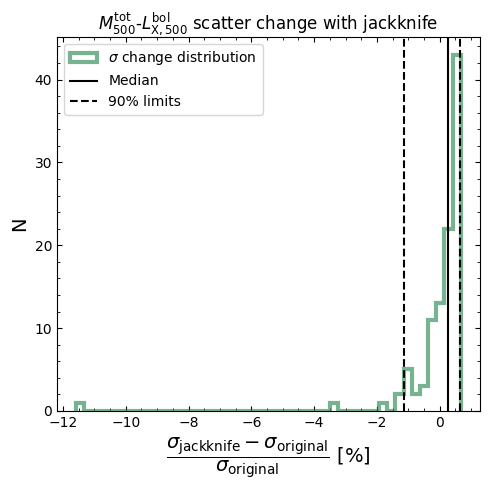

Median percentage change in scatter of 0.28%
90% confidence limits on percentage change in scatter of -1.12% to 0.64%



In [17]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot500_lxbol_500_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot500_lxbol_500_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot500_lxbol_500_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot500_lxbol_500_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')


plt.title(r'$M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [18]:
l1_mtot500_lxbol_500_domin = l1_mtot500_lxbol_500_res[l1_mtot500_lxbol_500_res['scatter_perc_change'] < cur_low]
l1_mtot500_lxbol_500_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
17,SDSSXCS-155,0.3695,0.0367,2.8959,0.2270,0.2029,0.0168,-1.241
34,SDSSXCS-22,0.3851,0.0337,2.9074,0.2096,0.1816,0.0157,-11.574
36,SDSSXCS-2282,0.3646,0.0372,2.9724,0.2375,0.2029,0.0168,-1.231
71,SDSSXCS-5159,0.3862,0.0372,2.8186,0.2244,0.2031,0.0165,-1.143
86,SDSSXCS-6955,0.3628,0.0369,2.9843,0.2368,0.2019,0.0165,-1.711
94,SDSSXCS-8060,0.3889,0.0366,2.7911,0.2194,0.1986,0.0165,-3.319


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [19]:
cur_samp_wo_domin = sdssxcs_samp_with_gm500[~sdssxcs_samp_with_gm500['name'].isin(l1_mtot500_lxbol_500_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot500 = Quantity(cur_samp_wo_domin[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')\
    *(cur_samp_wo_domin['E'].values[..., None]**2)
lx500_bol = Quantity(cur_samp_wo_domin[['Lxbol_500', 'Lxbol_500-','Lxbol_500+']].values, 'erg/s')

mtot500_lxbol_500_wo_domin = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], lx500_bol[:, 0], lx500_bol[:, 1:], m_norm, 
                                                   lx_norm, y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$", 
                                                   x_name=r"$L^{\rm{bol}}_{\rm{X,500}}$", dim_hubb_ind=2, 
                                                   point_names=cur_samp_wo_domin['name'].values)
mtot500_lxbol_500_wo_domin.model_colour = 'darkgreen'
mtot500_lxbol_500_wo_domin.author = 'Turner et al.'
mtot500_lxbol_500_wo_domin.year = 2025
mtot500_lxbol_500_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $E(z)^{2}M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500}}$"

  |**************************************************| 100%


In [20]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lxbol_500_wo_domin.pars[0][0], e=mtot500_lxbol_500_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lxbol_500_wo_domin.pars[1][0], e=mtot500_lxbol_500_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_lxbol_500_wo_domin.scatter_par[0], e=mtot500_lxbol_500_wo_domin.scatter_par[1]))

Slope of 0.382 ± 0.032

Normalisation of 2.885 ± 0.201

Scatter of 0.160 ± 0.014


### Assessing the $M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$ relation

In [21]:
l1_mtot500_lxbol_500ce_rels, l1_mtot500_lxbol_500ce_res = leave_one_jackknife(sdssxcs_samp_with_gm500, mtot500_lxbol_500ce, 
                                                                              x_cols=['Lxbol_500ce', 'Lxbol_500ce-', 'Lxbol_500ce+'],
                                                                              x_name=r"$L^{\rm{bol}}_{\rm{X,500ce}}$",
                                                                              x_norm=lx_norm, dim_hubb_ind=2, 
                                                                              y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$")

Fitting sub-sample scaling relations:   0%|                                           | 0/104 [00:00<?, ?it/s]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▎                                  | 1/104 [00:30<53:00, 30.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▋                                  | 2/104 [01:02<52:57, 31.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█                                  | 3/104 [01:33<52:15, 31.05s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▎                                 | 4/104 [02:04<51:47, 31.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▋                                 | 5/104 [02:35<51:07, 30.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   6%|██                                 | 6/104 [03:06<50:38, 31.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                | 7/104 [03:37<50:31, 31.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▋                                | 8/104 [04:09<50:07, 31.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███                                | 9/104 [04:40<49:26, 31.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▎                              | 10/104 [05:11<48:54, 31.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▌                              | 11/104 [05:43<48:35, 31.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|███▉                              | 12/104 [06:14<47:48, 31.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▎                             | 13/104 [06:44<47:06, 31.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                             | 14/104 [07:16<46:40, 31.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|████▉                             | 15/104 [07:46<46:01, 31.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▏                            | 16/104 [08:18<45:34, 31.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▌                            | 17/104 [08:49<45:11, 31.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  17%|█████▉                            | 18/104 [09:20<44:26, 31.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                           | 19/104 [09:51<43:54, 30.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                           | 20/104 [10:22<43:35, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▊                           | 21/104 [10:53<42:59, 31.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▏                          | 22/104 [11:23<42:13, 30.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▌                          | 23/104 [11:55<41:57, 31.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|███████▊                          | 24/104 [12:27<41:39, 31.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▏                         | 25/104 [12:59<41:32, 31.55s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▌                         | 26/104 [13:30<41:01, 31.56s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|████████▊                         | 27/104 [14:02<40:25, 31.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▏                        | 28/104 [14:33<39:48, 31.43s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  28%|█████████▍                        | 29/104 [15:05<39:23, 31.51s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|█████████▊                        | 30/104 [15:36<38:37, 31.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▏                       | 31/104 [16:07<37:59, 31.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▍                       | 32/104 [16:38<37:26, 31.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|██████████▊                       | 33/104 [17:09<37:03, 31.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████                       | 34/104 [17:40<36:28, 31.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▍                      | 35/104 [18:12<35:54, 31.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|███████████▊                      | 36/104 [18:43<35:29, 31.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████                      | 37/104 [19:14<34:56, 31.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|████████████▍                     | 38/104 [19:45<34:15, 31.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|████████████▊                     | 39/104 [20:16<33:39, 31.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████                     | 40/104 [20:47<33:14, 31.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  39%|█████████████▍                    | 41/104 [21:18<32:39, 31.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▋                    | 42/104 [21:50<32:19, 31.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████                    | 43/104 [22:22<32:00, 31.48s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▍                   | 44/104 [22:53<31:13, 31.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|██████████████▋                   | 45/104 [23:25<30:56, 31.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████                   | 46/104 [23:56<30:26, 31.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▎                  | 47/104 [24:27<29:43, 31.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|███████████████▋                  | 48/104 [24:58<29:11, 31.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████                  | 49/104 [25:30<28:44, 31.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▎                 | 50/104 [26:01<28:07, 31.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|████████████████▋                 | 51/104 [26:31<27:22, 30.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  50%|█████████████████                 | 52/104 [27:02<26:42, 30.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▎                | 53/104 [27:33<26:14, 30.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|█████████████████▋                | 54/104 [28:04<25:51, 31.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|█████████████████▉                | 55/104 [28:35<25:22, 31.07s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▎               | 56/104 [29:06<24:52, 31.09s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|██████████████████▋               | 57/104 [29:38<24:28, 31.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|██████████████████▉               | 58/104 [30:09<24:01, 31.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|███████████████████▎              | 59/104 [30:41<23:26, 31.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|███████████████████▌              | 60/104 [31:11<22:47, 31.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|███████████████████▉              | 61/104 [31:42<22:11, 30.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|████████████████████▎             | 62/104 [32:13<21:45, 31.09s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  61%|████████████████████▌             | 63/104 [32:45<21:24, 31.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|████████████████████▉             | 64/104 [33:17<20:55, 31.38s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▎            | 65/104 [33:47<20:14, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▌            | 66/104 [34:18<19:43, 31.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|█████████████████████▉            | 67/104 [34:50<19:13, 31.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▏           | 68/104 [35:21<18:39, 31.11s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|██████████████████████▌           | 69/104 [35:51<18:03, 30.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|██████████████████████▉           | 70/104 [36:22<17:30, 30.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▏          | 71/104 [36:53<16:56, 30.81s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|███████████████████████▌          | 72/104 [37:24<16:28, 30.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|███████████████████████▊          | 73/104 [37:55<15:59, 30.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|████████████████████████▏         | 74/104 [38:26<15:32, 31.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  72%|████████████████████████▌         | 75/104 [38:57<15:03, 31.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|████████████████████████▊         | 76/104 [39:29<14:35, 31.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▏        | 77/104 [40:01<14:07, 31.38s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|█████████████████████████▌        | 78/104 [40:32<13:34, 31.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|█████████████████████████▊        | 79/104 [41:04<13:06, 31.47s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▏       | 80/104 [41:36<12:39, 31.66s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|██████████████████████████▍       | 81/104 [42:08<12:13, 31.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|██████████████████████████▊       | 82/104 [42:40<11:42, 31.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|███████████████████████████▏      | 83/104 [43:12<11:11, 31.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|███████████████████████████▍      | 84/104 [43:44<10:39, 31.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|███████████████████████████▊      | 85/104 [44:16<10:07, 31.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  83%|████████████████████████████      | 86/104 [44:48<09:34, 31.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|████████████████████████████▍     | 87/104 [45:19<09:00, 31.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|████████████████████████████▊     | 88/104 [45:51<08:29, 31.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|█████████████████████████████     | 89/104 [46:23<07:57, 31.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|█████████████████████████████▍    | 90/104 [46:55<07:27, 31.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|█████████████████████████████▊    | 91/104 [47:28<06:56, 32.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████    | 92/104 [48:00<06:24, 32.08s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|██████████████████████████████▍   | 93/104 [48:32<05:52, 32.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|██████████████████████████████▋   | 94/104 [49:03<05:19, 31.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████   | 95/104 [49:35<04:46, 31.83s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|███████████████████████████████▍  | 96/104 [50:07<04:16, 32.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|███████████████████████████████▋  | 97/104 [50:40<03:44, 32.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  94%|████████████████████████████████  | 98/104 [51:11<03:11, 31.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|████████████████████████████████▎ | 99/104 [51:43<02:39, 32.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|███████████████████████████████▋ | 100/104 [52:15<02:07, 31.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|████████████████████████████████ | 101/104 [52:48<01:36, 32.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|████████████████████████████████▎| 102/104 [53:21<01:04, 32.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|████████████████████████████████▋| 103/104 [53:52<00:32, 32.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|█████████████████████████████████| 104/104 [54:25<00:00, 31.39s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [22]:
l1_mtot500_lxbol_500ce_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-lx/"\
                                 "mtot500_lxbol_500ce_l1_jackknife_rel_pars.csv")
l1_mtot500_lxbol_500ce_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.4191,0.0378,3.1175,0.2146,0.1944,0.0162,-0.101
1,SDSSXCS-10401,0.4048,0.0382,3.2171,0.2244,0.1929,0.0161,-0.870
2,SDSSXCS-110,0.4154,0.0376,3.1261,0.2141,0.1932,0.0162,-0.709
3,SDSSXCS-11154,0.4161,0.0379,3.1612,0.2178,0.1948,0.0162,0.141
4,SDSSXCS-1131,0.4157,0.0380,3.1499,0.2174,0.1948,0.0162,0.117
5,SDSSXCS-11331,0.4174,0.0377,3.1629,0.2163,0.1934,0.0162,-0.611


#### Diagnostic distribution of percentage change of scatter

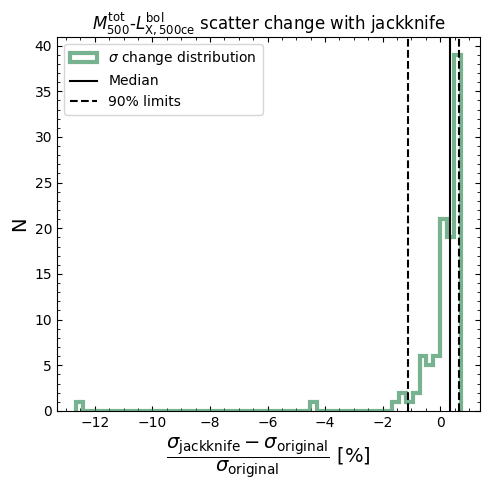

Median percentage change in scatter of 0.33%
90% confidence limits on percentage change in scatter of -1.12% to 0.66%



In [23]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot500_lxbol_500ce_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot500_lxbol_500ce_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot500_lxbol_500ce_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot500_lxbol_500ce_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')


plt.title(r'$M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [24]:
l1_mtot500_lxbol_500ce_domin = l1_mtot500_lxbol_500ce_res[l1_mtot500_lxbol_500ce_res['scatter_perc_change'] < cur_low]
l1_mtot500_lxbol_500ce_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
34,SDSSXCS-22,0.4250,0.0341,3.1722,0.1971,0.1700,0.0150,-12.643
36,SDSSXCS-2282,0.4056,0.0380,3.2157,0.2232,0.1922,0.0161,-1.198
58,SDSSXCS-382,0.4244,0.0377,3.0855,0.2121,0.1923,0.0161,-1.161
71,SDSSXCS-5159,0.4282,0.0379,3.0710,0.2114,0.1919,0.0158,-1.346
86,SDSSXCS-6955,0.4037,0.0376,3.2262,0.2213,0.1913,0.0159,-1.659
94,SDSSXCS-8060,0.4329,0.0369,3.0334,0.2045,0.1860,0.0157,-4.426


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [25]:
cur_samp_wo_domin = sdssxcs_samp_with_gm500[~sdssxcs_samp_with_gm500['name'].isin(l1_mtot500_lxbol_500ce_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot500 = Quantity(cur_samp_wo_domin[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')\
    *(cur_samp_wo_domin['E'].values[..., None]**2)
lx500ce_bol = Quantity(cur_samp_wo_domin[['Lxbol_500ce', 'Lxbol_500ce-','Lxbol_500ce+']].values, 'erg/s')

mtot500_lxbol_500ce_wo_domin = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], lx500ce_bol[:, 0], lx500ce_bol[:, 1:], m_norm, 
                                                     lx_norm, y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$", 
                                                     x_name=r"$L^{\rm{bol}}_{\rm{X,500ce}}$", dim_hubb_ind=2, 
                                                     point_names=cur_samp_wo_domin['name'].values)
mtot500_lxbol_500ce_wo_domin.model_colour = 'lightseagreen'
mtot500_lxbol_500ce_wo_domin.author = 'Turner et al.'
mtot500_lxbol_500ce_wo_domin.year = 2025
mtot500_lxbol_500ce_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $E(z)^{2}M^{\rm{tot}}_{500}$-$L^{\rm{bol}}_{\rm{X,500ce}}$"

  |**************************************************| 100%


In [26]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lxbol_500ce_wo_domin.pars[0][0], e=mtot500_lxbol_500ce_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lxbol_500ce_wo_domin.pars[1][0], e=mtot500_lxbol_500ce_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_lxbol_500ce_wo_domin.scatter_par[0], e=mtot500_lxbol_500ce_wo_domin.scatter_par[1]))

Slope of 0.441 ± 0.032

Normalisation of 3.051 ± 0.183

Scatter of 0.145 ± 0.014


### Assessing the $M^{\rm{tot}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ relation

In [27]:
l1_mtot2500_lxbol_2500_rels, l1_mtot2500_lxbol_2500_res = leave_one_jackknife(sdssxcs_samp_with_gm2500, mtot2500_lxbol_2500, 
                                                                              x_cols=['Lxbol_2500', 'Lxbol_2500-', 'Lxbol_2500+'],
                                                                              x_name=r"$L^{\rm{bol}}_{\rm{X,2500}}$", 
                                                                              x_norm=lx_norm, dim_hubb_ind=2, 
                                                                              y_name=r"$E(z)^{2}M^{\rm{tot}}_{2500}$")

Fitting sub-sample scaling relations:   0%|                                            | 0/91 [00:00<?, ?it/s]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▍                                   | 1/91 [00:27<41:11, 27.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▊                                   | 2/91 [00:55<41:30, 27.98s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█▏                                  | 3/91 [01:24<41:26, 28.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▌                                  | 4/91 [01:52<40:37, 28.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▉                                  | 5/91 [02:19<39:57, 27.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                 | 6/91 [02:47<39:39, 27.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▊                                 | 7/91 [03:15<39:11, 28.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███▏                                | 8/91 [03:43<38:43, 27.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▌                                | 9/91 [04:11<38:08, 27.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▊                               | 10/91 [04:40<38:01, 28.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▏                              | 11/91 [05:07<37:19, 27.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                              | 12/91 [05:35<36:34, 27.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|█████                              | 13/91 [06:02<35:55, 27.64s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▍                             | 14/91 [06:29<35:17, 27.50s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▊                             | 15/91 [06:57<34:46, 27.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                            | 16/91 [07:24<34:11, 27.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                            | 17/91 [07:51<33:35, 27.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▉                            | 18/91 [08:18<33:04, 27.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▎                           | 19/91 [08:46<33:00, 27.51s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▋                           | 20/91 [09:13<32:23, 27.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|████████                           | 21/91 [09:41<32:00, 27.43s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▍                          | 22/91 [10:08<31:26, 27.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▊                          | 23/91 [10:35<30:57, 27.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|█████████▏                         | 24/91 [11:02<30:29, 27.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▌                         | 25/91 [11:29<30:00, 27.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|██████████                         | 26/91 [11:57<29:29, 27.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▍                        | 27/91 [12:24<29:07, 27.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▊                        | 28/91 [12:51<28:39, 27.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|███████████▏                       | 29/91 [13:19<28:09, 27.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████▌                       | 30/91 [13:45<27:35, 27.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▉                       | 31/91 [14:12<27:06, 27.11s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|████████████▎                      | 32/91 [14:40<26:39, 27.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████▋                      | 33/91 [15:07<26:13, 27.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|█████████████                      | 34/91 [15:34<25:50, 27.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████▍                     | 35/91 [16:02<25:30, 27.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▊                     | 36/91 [16:29<24:58, 27.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████▏                    | 37/91 [16:56<24:31, 27.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▌                    | 38/91 [17:23<24:06, 27.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|███████████████                    | 39/91 [17:50<23:36, 27.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████▍                   | 40/91 [18:18<23:09, 27.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▊                   | 41/91 [18:45<22:39, 27.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|████████████████▏                  | 42/91 [19:12<22:12, 27.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████▌                  | 43/91 [19:39<21:47, 27.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▉                  | 44/91 [20:07<21:18, 27.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|█████████████████▎                 | 45/91 [20:34<20:50, 27.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▋                 | 46/91 [21:01<20:20, 27.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|██████████████████                 | 47/91 [21:28<19:58, 27.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|██████████████████▍                | 48/91 [21:56<19:36, 27.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▊                | 49/91 [22:23<19:07, 27.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|███████████████████▏               | 50/91 [22:50<18:34, 27.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|███████████████████▌               | 51/91 [23:16<17:58, 26.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|████████████████████               | 52/91 [23:43<17:31, 26.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|████████████████████▍              | 53/91 [24:10<16:57, 26.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|████████████████████▊              | 54/91 [24:36<16:31, 26.80s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|█████████████████████▏             | 55/91 [25:03<16:02, 26.73s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▌             | 56/91 [25:30<15:36, 26.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▉             | 57/91 [25:57<15:10, 26.79s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|██████████████████████▎            | 58/91 [26:24<14:45, 26.83s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▋            | 59/91 [26:50<14:16, 26.76s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|███████████████████████            | 60/91 [27:17<13:49, 26.76s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|███████████████████████▍           | 61/91 [27:44<13:21, 26.71s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▊           | 62/91 [28:10<12:48, 26.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|████████████████████████▏          | 63/91 [28:36<12:18, 26.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|████████████████████████▌          | 64/91 [29:02<11:48, 26.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|█████████████████████████          | 65/91 [29:28<11:22, 26.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|█████████████████████████▍         | 66/91 [29:54<10:54, 26.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▊         | 67/91 [30:20<10:27, 26.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|██████████████████████████▏        | 68/91 [30:46<10:01, 26.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|██████████████████████████▌        | 69/91 [31:12<09:35, 26.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▉        | 70/91 [31:38<09:09, 26.15s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|███████████████████████████▎       | 71/91 [32:05<08:45, 26.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|███████████████████████████▋       | 72/91 [32:31<08:20, 26.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|████████████████████████████       | 73/91 [32:57<07:52, 26.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|████████████████████████████▍      | 74/91 [33:24<07:24, 26.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|████████████████████████████▊      | 75/91 [33:49<06:57, 26.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|█████████████████████████████▏     | 76/91 [34:16<06:32, 26.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|█████████████████████████████▌     | 77/91 [34:42<06:05, 26.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|██████████████████████████████     | 78/91 [35:08<05:39, 26.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|██████████████████████████████▍    | 79/91 [35:34<05:13, 26.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████▊    | 80/91 [36:00<04:47, 26.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|███████████████████████████████▏   | 81/91 [36:26<04:21, 26.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|███████████████████████████████▌   | 82/91 [36:53<03:55, 26.17s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████▉   | 83/91 [37:19<03:30, 26.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|████████████████████████████████▎  | 84/91 [37:46<03:04, 26.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|████████████████████████████████▋  | 85/91 [38:12<02:37, 26.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|█████████████████████████████████  | 86/91 [38:38<02:11, 26.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|█████████████████████████████████▍ | 87/91 [39:04<01:45, 26.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|█████████████████████████████████▊ | 88/91 [39:31<01:18, 26.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|██████████████████████████████████▏| 89/91 [39:57<00:52, 26.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|██████████████████████████████████▌| 90/91 [40:23<00:26, 26.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|███████████████████████████████████| 91/91 [40:49<00:00, 26.92s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [28]:
l1_mtot2500_lxbol_2500_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-lx/"\
                                  "mtot2500_lxbol_2500_l1_jackknife_rel_pars.csv")
l1_mtot2500_lxbol_2500_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.3585,0.0424,3.3940,0.2645,0.2297,0.0200,50.747
1,SDSSXCS-10401,0.3456,0.0426,3.4941,0.2729,0.2267,0.0198,48.746
2,SDSSXCS-110,0.3559,0.0422,3.3920,0.2612,0.2283,0.0199,49.837
3,SDSSXCS-11154,0.3576,0.0424,3.4266,0.2656,0.2297,0.0200,50.748
4,SDSSXCS-1131,0.3567,0.0422,3.4202,0.2636,0.2290,0.0199,50.301
5,SDSSXCS-11331,0.3629,0.0419,3.4273,0.2609,0.2263,0.0199,48.484


#### Diagnostic distribution of percentage change of scatter

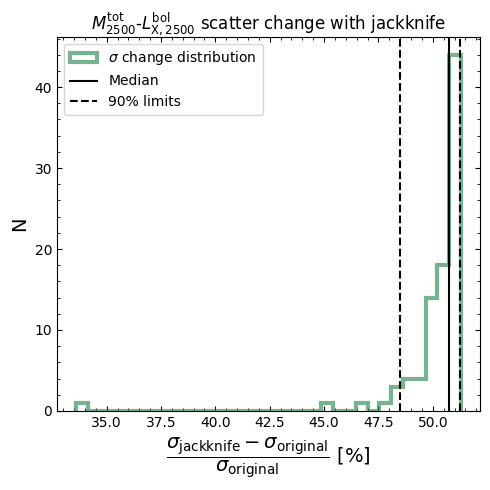

Median percentage change in scatter of 50.75%
90% confidence limits on percentage change in scatter of 48.49% to 51.24%



In [29]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot2500_lxbol_2500_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot2500_lxbol_2500_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot2500_lxbol_2500_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot2500_lxbol_2500_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')

plt.title(r'$M^{\rm{tot}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [30]:
l1_mtot2500_lxbol_2500_domin = l1_mtot2500_lxbol_2500_res[l1_mtot2500_lxbol_2500_res['scatter_perc_change'] < cur_low]
l1_mtot2500_lxbol_2500_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
5,SDSSXCS-11331,0.3629,0.0419,3.4273,0.2609,0.2263,0.0199,48.484
28,SDSSXCS-22,0.3727,0.0384,3.4385,0.2403,0.2036,0.0185,33.603
60,SDSSXCS-5159,0.3745,0.0424,3.3068,0.2561,0.2252,0.0194,47.761
74,SDSSXCS-6955,0.3452,0.0417,3.5057,0.2682,0.2240,0.0195,46.977
82,SDSSXCS-8060,0.3736,0.0416,3.2962,0.2517,0.2212,0.0194,45.162


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [31]:
cur_samp_wo_domin = sdssxcs_samp_with_gm2500[~sdssxcs_samp_with_gm2500['name'].isin(l1_mtot2500_lxbol_2500_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot2500 = Quantity(cur_samp_wo_domin[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')\
    *(cur_samp_wo_domin['E'].values[..., None]**2)
lx2500_bol = Quantity(cur_samp_wo_domin[['Lxbol_2500', 'Lxbol_2500-','Lxbol_2500+']].values, 'erg/s')

mtot2500_lxbol_2500_wo_domin = scaling_relation_lira(mtot2500[:, 0], mtot2500[:, 1:], lx2500_bol[:, 0], lx2500_bol[:, 1:], m_norm, 
                                                     lx_norm, y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$", 
                                                     x_name=r"$L^{\rm{bol}}_{\rm{X,2500}}$", dim_hubb_ind=2, 
                                                     point_names=cur_samp_wo_domin['name'].values)
mtot2500_lxbol_2500_wo_domin.model_colour = 'thistle'
mtot2500_lxbol_2500_wo_domin.author = 'Turner et al.'
mtot2500_lxbol_2500_wo_domin.year = 2025
mtot2500_lxbol_2500_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $E(z)^{2}M^{\rm{tot}}_{2500}$-$L^{\rm{bol}}_{\rm{X,2500}}$"

  |**************************************************| 100%


In [32]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_lxbol_2500_wo_domin.pars[0][0], e=mtot2500_lxbol_2500_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_lxbol_2500_wo_domin.pars[1][0], e=mtot2500_lxbol_2500_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_lxbol_2500_wo_domin.scatter_par[0], e=mtot2500_lxbol_2500_wo_domin.scatter_par[1]))

Slope of 0.412 ± 0.028

Normalisation of 1.098 ± 0.057

Scatter of 0.137 ± 0.012


### Assessing the $M^{\rm{tot}}_{500}$-$L^{\rm{0.5-2.0}}_{\rm{X,500}}$ relation

In [33]:
l1_mtot500_lx52_500_rels, l1_mtot500_lx52_500_res = leave_one_jackknife(sdssxcs_samp_with_gm500, mtot500_lx52_500, 
                                                                        x_cols=['Lx52_500', 'Lx52_500-', 'Lx52_500+'],
                                                                        x_name=r"$L^{0.5-2.0}_{\rm{X,500}}$", 
                                                                        x_norm=lx_norm, dim_hubb_ind=2, 
                                                                        y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$")

Fitting sub-sample scaling relations:   0%|                                           | 0/104 [00:00<?, ?it/s]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▎                                  | 1/104 [00:30<52:15, 30.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▋                                  | 2/104 [01:00<51:46, 30.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█                                  | 3/104 [01:31<51:14, 30.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▎                                 | 4/104 [02:01<50:41, 30.42s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▋                                 | 5/104 [02:32<50:08, 30.39s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   6%|██                                 | 6/104 [03:02<49:43, 30.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                | 7/104 [03:32<49:09, 30.41s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▋                                | 8/104 [04:03<48:43, 30.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███                                | 9/104 [04:33<48:09, 30.42s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▎                              | 10/104 [05:04<47:43, 30.46s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▌                              | 11/104 [05:34<47:03, 30.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|███▉                              | 12/104 [06:04<46:32, 30.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▎                             | 13/104 [06:35<46:01, 30.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                             | 14/104 [07:05<45:26, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|████▉                             | 15/104 [07:35<44:52, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▏                            | 16/104 [08:05<44:17, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▌                            | 17/104 [08:35<43:46, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  17%|█████▉                            | 18/104 [09:06<43:23, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                           | 19/104 [09:36<42:47, 30.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                           | 20/104 [10:06<42:17, 30.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▊                           | 21/104 [10:36<41:47, 30.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▏                          | 22/104 [11:06<41:17, 30.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▌                          | 23/104 [11:37<40:46, 30.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|███████▊                          | 24/104 [12:07<40:14, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▏                         | 25/104 [12:37<39:44, 30.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▌                         | 26/104 [13:07<39:14, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|████████▊                         | 27/104 [13:37<38:42, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▏                        | 28/104 [14:07<38:11, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  28%|█████████▍                        | 29/104 [14:38<37:47, 30.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|█████████▊                        | 30/104 [15:08<37:18, 30.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▏                       | 31/104 [15:38<36:48, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▍                       | 32/104 [16:09<36:19, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|██████████▊                       | 33/104 [16:39<35:47, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████                       | 34/104 [17:09<35:19, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▍                      | 35/104 [17:40<34:54, 30.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|███████████▊                      | 36/104 [18:10<34:22, 30.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████                      | 37/104 [18:40<33:49, 30.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|████████████▍                     | 38/104 [19:10<33:16, 30.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|████████████▊                     | 39/104 [19:41<32:45, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████                     | 40/104 [20:11<32:15, 30.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  39%|█████████████▍                    | 41/104 [20:41<31:46, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▋                    | 42/104 [21:11<31:13, 30.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████                    | 43/104 [21:42<30:44, 30.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▍                   | 44/104 [22:12<30:18, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|██████████████▋                   | 45/104 [22:42<29:46, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████                   | 46/104 [23:13<29:17, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▎                  | 47/104 [23:43<28:46, 30.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|███████████████▋                  | 48/104 [24:13<28:17, 30.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████                  | 49/104 [24:43<27:44, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▎                 | 50/104 [25:14<27:15, 30.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|████████████████▋                 | 51/104 [25:44<26:48, 30.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  50%|█████████████████                 | 52/104 [26:14<26:16, 30.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▎                | 53/104 [26:45<25:46, 30.33s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|█████████████████▋                | 54/104 [27:15<25:14, 30.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|█████████████████▉                | 55/104 [27:45<24:43, 30.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▎               | 56/104 [28:15<24:12, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|██████████████████▋               | 57/104 [28:46<23:44, 30.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|██████████████████▉               | 58/104 [29:16<23:14, 30.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|███████████████████▎              | 59/104 [29:47<22:49, 30.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|███████████████████▌              | 60/104 [30:17<22:19, 30.44s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|███████████████████▉              | 61/104 [30:47<21:43, 30.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|████████████████████▎             | 62/104 [31:17<21:09, 30.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  61%|████████████████████▌             | 63/104 [31:47<20:37, 30.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|████████████████████▉             | 64/104 [32:17<20:05, 30.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▎            | 65/104 [32:47<19:32, 30.06s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▌            | 66/104 [33:18<19:03, 30.10s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|█████████████████████▉            | 67/104 [33:48<18:34, 30.13s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▏           | 68/104 [34:18<18:05, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|██████████████████████▌           | 69/104 [34:48<17:34, 30.12s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|██████████████████████▉           | 70/104 [35:18<17:05, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▏          | 71/104 [35:48<16:35, 30.16s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|███████████████████████▌          | 72/104 [36:19<16:08, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|███████████████████████▊          | 73/104 [36:50<15:41, 30.36s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|████████████████████████▏         | 74/104 [37:20<15:07, 30.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  72%|████████████████████████▌         | 75/104 [37:49<14:34, 30.14s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|████████████████████████▊         | 76/104 [38:19<14:01, 30.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▏        | 77/104 [38:49<13:30, 30.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|█████████████████████████▌        | 78/104 [39:19<13:00, 30.02s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|█████████████████████████▊        | 79/104 [39:49<12:27, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▏       | 80/104 [40:19<11:56, 29.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|██████████████████████████▍       | 81/104 [40:49<11:27, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|██████████████████████████▊       | 82/104 [41:18<10:57, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|███████████████████████████▏      | 83/104 [41:48<10:27, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|███████████████████████████▍      | 84/104 [42:18<09:57, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|███████████████████████████▊      | 85/104 [42:48<09:27, 29.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  83%|████████████████████████████      | 86/104 [43:18<08:57, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|████████████████████████████▍     | 87/104 [43:48<08:28, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|████████████████████████████▊     | 88/104 [44:18<07:59, 29.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|█████████████████████████████     | 89/104 [44:48<07:29, 29.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|█████████████████████████████▍    | 90/104 [45:18<07:00, 30.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|█████████████████████████████▊    | 91/104 [45:48<06:29, 29.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████    | 92/104 [46:18<05:59, 29.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|██████████████████████████████▍   | 93/104 [46:48<05:29, 29.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|██████████████████████████████▋   | 94/104 [47:18<04:59, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████   | 95/104 [47:48<04:29, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|███████████████████████████████▍  | 96/104 [48:18<03:59, 29.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|███████████████████████████████▋  | 97/104 [48:47<03:29, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  94%|████████████████████████████████  | 98/104 [49:17<02:59, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|████████████████████████████████▎ | 99/104 [49:47<02:29, 29.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|███████████████████████████████▋ | 100/104 [50:17<01:59, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|████████████████████████████████ | 101/104 [50:47<01:29, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|████████████████████████████████▎| 102/104 [51:17<00:59, 29.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|████████████████████████████████▋| 103/104 [51:47<00:29, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|█████████████████████████████████| 104/104 [52:16<00:00, 30.16s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [34]:
l1_mtot500_lx52_500_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-lx/"\
                               "mtot500_lx52_500_l1_jackknife_rel_pars.csv")
l1_mtot500_lx52_500_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.4109,0.0445,4.3751,0.2518,0.2163,0.0176,0.180
1,SDSSXCS-10401,0.3954,0.0447,4.4646,0.2557,0.2137,0.0175,-1.029
2,SDSSXCS-110,0.4079,0.0441,4.3681,0.2484,0.2149,0.0176,-0.488
3,SDSSXCS-11154,0.4090,0.0445,4.4173,0.2534,0.2164,0.0177,0.224
4,SDSSXCS-1131,0.4083,0.0443,4.4028,0.2514,0.2162,0.0176,0.105
5,SDSSXCS-11331,0.4147,0.0440,4.4276,0.2501,0.2132,0.0175,-1.290


#### Diagnostic distribution of percentage change of scatter

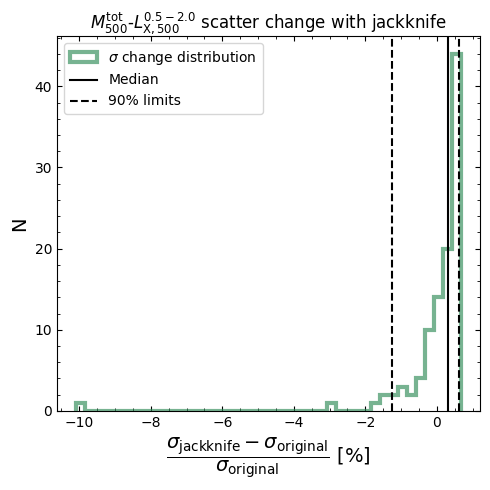

Median percentage change in scatter of 0.30%
90% confidence limits on percentage change in scatter of -1.27% to 0.63%



In [35]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot500_lx52_500_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot500_lx52_500_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot500_lx52_500_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot500_lx52_500_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')


plt.title(r'$M^{\rm{tot}}_{500}$-$L^{0.5-2.0}_{\rm{X,500}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [36]:
l1_mtot500_lx52_500_domin = l1_mtot500_lx52_500_res[l1_mtot500_lx52_500_res['scatter_perc_change'] < cur_low]
l1_mtot500_lx52_500_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
5,SDSSXCS-11331,0.4147,0.0440,4.4276,0.2501,0.2132,0.0175,-1.290
17,SDSSXCS-155,0.4031,0.0439,4.3669,0.2467,0.2129,0.0174,-1.419
34,SDSSXCS-22,0.4208,0.0405,4.4645,0.2336,0.1942,0.0165,-10.082
36,SDSSXCS-2282,0.3969,0.0442,4.4663,0.2542,0.2130,0.0174,-1.357
86,SDSSXCS-6955,0.3946,0.0441,4.4738,0.2531,0.2120,0.0172,-1.812
94,SDSSXCS-8060,0.4257,0.0437,4.3024,0.2422,0.2095,0.0172,-2.986


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [37]:
cur_samp_wo_domin = sdssxcs_samp_with_gm500[~sdssxcs_samp_with_gm500['name'].isin(l1_mtot500_lx52_500_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot500 = Quantity(cur_samp_wo_domin[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')\
    *(cur_samp_wo_domin['E'].values[..., None]**2)
lx500_52 = Quantity(cur_samp_wo_domin[['Lx52_500', 'Lx52_500-','Lx52_500+']].values, 'erg/s')

mtot500_lx52_500_wo_domin = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], lx500_52[:, 0], lx500_52[:, 1:], m_norm, 
                                                   lx_norm, y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$", 
                                                   x_name=r"$L^{0.5-2.0}_{\rm{X,500}}$", dim_hubb_ind=2, 
                                                   point_names=cur_samp_wo_domin['name'].values)
mtot500_lx52_500_wo_domin.model_colour = 'darkorange'
mtot500_lx52_500_wo_domin.author = 'Turner et al.'
mtot500_lx52_500_wo_domin.year = 2025
mtot500_lx52_500_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $E(z)^{2}M^{\rm{tot}}_{500}$-$L^{0.5-2.0}_{\rm{X,500}}$"

  |**************************************************| 100%


In [38]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lx52_500_wo_domin.pars[0][0], e=mtot500_lx52_500_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lx52_500_wo_domin.pars[1][0], e=mtot500_lx52_500_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_lx52_500_wo_domin.scatter_par[0], e=mtot500_lx52_500_wo_domin.scatter_par[1]))

Slope of 0.412 ± 0.038

Normalisation of 4.511 ± 0.219

Scatter of 0.169 ± 0.015


### Assessing the $M^{\rm{tot}}_{500}$-$L^{\rm{0.5-2.0}}_{\rm{X,500ce}}$ relation

In [39]:
l1_mtot500_lx52_500ce_rels, l1_mtot500_lx52_500ce_res = leave_one_jackknife(sdssxcs_samp_with_gm500, mtot500_lx52_500ce, 
                                                                            x_cols=['Lx52_500ce', 'Lx52_500ce-', 'Lx52_500ce+'],
                                                                            x_name=r"$L^{0.5-2.0}_{\rm{X,500ce}}$",
                                                                            x_norm=lx_norm, dim_hubb_ind=2, 
                                                                            y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$")

Fitting sub-sample scaling relations:   0%|                                           | 0/104 [00:00<?, ?it/s]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▎                                  | 1/104 [00:29<51:24, 29.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▋                                  | 2/104 [00:59<50:50, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█                                  | 3/104 [01:29<50:21, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▎                                 | 4/104 [01:59<49:51, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▋                                 | 5/104 [02:29<49:28, 29.99s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   6%|██                                 | 6/104 [02:59<48:55, 29.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                | 7/104 [03:29<48:21, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▋                                | 8/104 [03:59<47:51, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███                                | 9/104 [04:29<47:23, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▎                              | 10/104 [04:59<46:53, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▌                              | 11/104 [05:29<46:19, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|███▉                              | 12/104 [05:59<45:50, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▎                             | 13/104 [06:28<45:20, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                             | 14/104 [06:58<44:52, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|████▉                             | 15/104 [07:28<44:23, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▏                            | 16/104 [07:58<43:43, 29.81s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▌                            | 17/104 [08:27<43:05, 29.72s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  17%|█████▉                            | 18/104 [08:57<42:32, 29.69s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                           | 19/104 [09:27<42:11, 29.79s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                           | 20/104 [09:57<41:44, 29.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▊                           | 21/104 [10:27<41:16, 29.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▏                          | 22/104 [10:57<40:45, 29.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▌                          | 23/104 [11:26<40:15, 29.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|███████▊                          | 24/104 [11:56<39:49, 29.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▏                         | 25/104 [12:26<39:21, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▌                         | 26/104 [12:56<38:53, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|████████▊                         | 27/104 [13:26<38:23, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▏                        | 28/104 [13:56<37:50, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  28%|█████████▍                        | 29/104 [14:26<37:23, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|█████████▊                        | 30/104 [14:56<36:54, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▏                       | 31/104 [15:26<36:24, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▍                       | 32/104 [15:56<35:51, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|██████████▊                       | 33/104 [16:26<35:23, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████                       | 34/104 [16:56<34:55, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▍                      | 35/104 [17:25<34:22, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|███████████▊                      | 36/104 [17:55<33:51, 29.87s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████                      | 37/104 [18:25<33:22, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|████████████▍                     | 38/104 [18:55<32:53, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|████████████▊                     | 39/104 [19:25<32:25, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████                     | 40/104 [19:55<31:54, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  39%|█████████████▍                    | 41/104 [20:25<31:22, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▋                    | 42/104 [20:55<30:55, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████                    | 43/104 [21:25<30:26, 29.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▍                   | 44/104 [21:55<29:53, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|██████████████▋                   | 45/104 [22:24<29:20, 29.83s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████                   | 46/104 [22:54<28:52, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▎                  | 47/104 [23:24<28:27, 29.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|███████████████▋                  | 48/104 [23:54<27:55, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████                  | 49/104 [24:24<27:26, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▎                 | 50/104 [24:54<26:55, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|████████████████▋                 | 51/104 [25:24<26:24, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  50%|█████████████████                 | 52/104 [25:53<25:48, 29.78s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▎                | 53/104 [26:23<25:16, 29.73s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|█████████████████▋                | 54/104 [26:53<24:47, 29.76s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|█████████████████▉                | 55/104 [27:23<24:18, 29.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▎               | 56/104 [27:53<23:52, 29.85s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|██████████████████▋               | 57/104 [28:23<23:22, 29.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|██████████████████▉               | 58/104 [28:52<22:54, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|███████████████████▎              | 59/104 [29:22<22:25, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|███████████████████▌              | 60/104 [29:52<21:53, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|███████████████████▉              | 61/104 [30:22<21:21, 29.81s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|████████████████████▎             | 62/104 [30:52<20:52, 29.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  61%|████████████████████▌             | 63/104 [31:22<20:22, 29.83s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|████████████████████▉             | 64/104 [31:51<19:52, 29.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▎            | 65/104 [32:21<19:24, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▌            | 66/104 [32:51<18:56, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|█████████████████████▉            | 67/104 [33:21<18:25, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▏           | 68/104 [33:51<17:57, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|██████████████████████▌           | 69/104 [34:21<17:28, 29.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|██████████████████████▉           | 70/104 [34:51<17:00, 30.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▏          | 71/104 [35:21<16:29, 29.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|███████████████████████▌          | 72/104 [35:51<16:01, 30.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|███████████████████████▊          | 73/104 [36:21<15:31, 30.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|████████████████████████▏         | 74/104 [36:51<14:59, 29.97s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  72%|████████████████████████▌         | 75/104 [37:21<14:28, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|████████████████████████▊         | 76/104 [37:51<13:57, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▏        | 77/104 [38:21<13:26, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|█████████████████████████▌        | 78/104 [38:51<12:56, 29.85s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|█████████████████████████▊        | 79/104 [39:21<12:27, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▏       | 80/104 [39:51<11:58, 29.92s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|██████████████████████████▍       | 81/104 [40:20<11:27, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|██████████████████████████▊       | 82/104 [40:51<10:59, 29.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|███████████████████████████▏      | 83/104 [41:21<10:29, 29.96s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|███████████████████████████▍      | 84/104 [41:50<09:58, 29.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|███████████████████████████▊      | 85/104 [42:20<09:28, 29.90s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  83%|████████████████████████████      | 86/104 [42:51<09:00, 30.03s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|████████████████████████████▍     | 87/104 [43:21<08:30, 30.04s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|████████████████████████████▊     | 88/104 [43:50<07:59, 30.00s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|█████████████████████████████     | 89/104 [44:21<07:30, 30.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|█████████████████████████████▍    | 90/104 [44:51<07:00, 30.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|█████████████████████████████▊    | 91/104 [45:21<06:30, 30.01s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████    | 92/104 [45:50<05:59, 29.94s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|██████████████████████████████▍   | 93/104 [46:20<05:28, 29.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|██████████████████████████████▋   | 94/104 [46:50<04:58, 29.89s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████   | 95/104 [47:20<04:28, 29.79s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|███████████████████████████████▍  | 96/104 [47:49<03:57, 29.72s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|███████████████████████████████▋  | 97/104 [48:19<03:27, 29.66s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  94%|████████████████████████████████  | 98/104 [48:48<02:57, 29.62s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|████████████████████████████████▎ | 99/104 [49:18<02:28, 29.70s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|███████████████████████████████▋ | 100/104 [49:48<01:58, 29.74s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|████████████████████████████████ | 101/104 [50:18<01:29, 29.86s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|████████████████████████████████▎| 102/104 [50:48<00:59, 29.83s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|████████████████████████████████▋| 103/104 [51:18<00:29, 29.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|█████████████████████████████████| 104/104 [51:47<00:00, 29.88s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [40]:
l1_mtot500_lx52_500ce_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-lx/"\
                                 "mtot500_lx52_500ce_l1_jackknife_rel_pars.csv")
l1_mtot500_lx52_500ce_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.4689,0.0458,5.0453,0.2564,0.2038,0.0169,-0.050
1,SDSSXCS-10401,0.4516,0.0461,5.1242,0.2596,0.2018,0.0168,-1.014
2,SDSSXCS-110,0.4652,0.0454,5.0350,0.2538,0.2023,0.0168,-0.773
3,SDSSXCS-11154,0.4660,0.0457,5.0979,0.2594,0.2042,0.0169,0.127
4,SDSSXCS-1131,0.4649,0.0459,5.0775,0.2580,0.2040,0.0168,0.065
5,SDSSXCS-11331,0.4685,0.0454,5.1135,0.2583,0.2021,0.0169,-0.876


#### Diagnostic distribution of percentage change of scatter

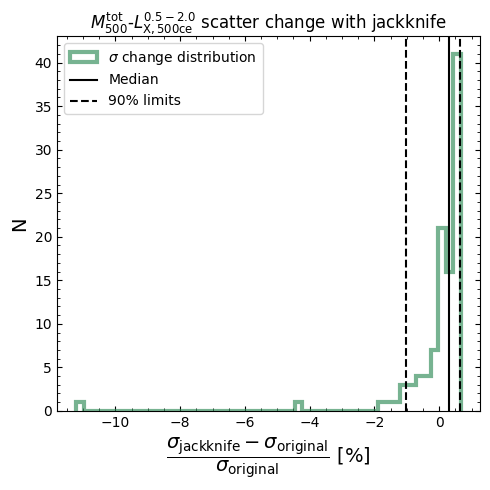

Median percentage change in scatter of 0.31%
90% confidence limits on percentage change in scatter of -1.01% to 0.65%



In [41]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot500_lx52_500ce_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot500_lx52_500ce_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot500_lx52_500ce_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot500_lx52_500ce_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')


plt.title(r'$M^{\rm{tot}}_{500}$-$L^{0.5-2.0}_{\rm{X,500ce}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [42]:
l1_mtot500_lx52_500ce_domin = l1_mtot500_lx52_500ce_res[l1_mtot500_lx52_500ce_res['scatter_perc_change'] < cur_low]
l1_mtot500_lx52_500ce_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
1,SDSSXCS-10401,0.4516,0.0461,5.1242,0.2596,0.2018,0.0168,-1.014
34,SDSSXCS-22,0.4766,0.0416,5.1687,0.2370,0.1810,0.0158,-11.210
36,SDSSXCS-2282,0.4532,0.0457,5.1275,0.2574,0.2011,0.0167,-1.397
71,SDSSXCS-5159,0.4826,0.0459,5.0149,0.2512,0.2008,0.0165,-1.542
86,SDSSXCS-6955,0.4509,0.0456,5.1314,0.2570,0.2003,0.0165,-1.752
94,SDSSXCS-8060,0.4875,0.0447,4.9821,0.2445,0.1951,0.0164,-4.331


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [43]:
cur_samp_wo_domin = sdssxcs_samp_with_gm500[~sdssxcs_samp_with_gm500['name'].isin(l1_mtot500_lx52_500ce_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot500 = Quantity(cur_samp_wo_domin[['Mhy500_wraderr', 'Mhy500_wraderr-', 'Mhy500_wraderr+']].values*1e+14, 'Msun')\
    *(cur_samp_wo_domin['E'].values[..., None]**2)
lx500ce_52 = Quantity(cur_samp_wo_domin[['Lx52_500ce', 'Lx52_500ce-','Lx52_500ce+']].values, 'erg/s')

mtot500_lx52_500ce_wo_domin = scaling_relation_lira(mtot500[:, 0], mtot500[:, 1:], lx500ce_52[:, 0], lx500ce_52[:, 1:], m_norm, 
                                                    lx_norm, y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$", 
                                                    x_name=r"$L^{0.5-2.0}_{\rm{X,500ce}}$", dim_hubb_ind=2, 
                                                    point_names=cur_samp_wo_domin['name'].values)
mtot500_lx52_500ce_wo_domin.model_colour = 'rosybrown'
mtot500_lx52_500ce_wo_domin.author = 'Turner et al.'
mtot500_lx52_500ce_wo_domin.year = 2025
mtot500_lx52_500ce_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $E(z)^{2}M^{\rm{tot}}_{500}$-$L^{0.5-2.0}_{\rm{X,500ce}}$"

  |**************************************************| 100%


In [44]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lx52_500ce_wo_domin.pars[0][0], e=mtot500_lx52_500ce_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot500_lx52_500ce_wo_domin.pars[1][0], e=mtot500_lx52_500ce_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot500_lx52_500ce_wo_domin.scatter_par[0], e=mtot500_lx52_500ce_wo_domin.scatter_par[1]))

Slope of 0.472 ± 0.040

Normalisation of 5.182 ± 0.219

Scatter of 0.156 ± 0.014


### Assessing the $M^{\rm{tot}}_{2500}$-$L^{\rm{0.5-2.0}}_{\rm{X,2500}}$ relation

In [45]:
l1_mtot2500_lx52_2500_rels, l1_mtot2500_lx52_2500_res = leave_one_jackknife(sdssxcs_samp_with_gm2500, mtot2500_lx52_2500, 
                                                                            x_cols=['Lx52_2500', 'Lx52_2500-', 'Lx52_2500+'],
                                                                            x_name=r"$L^{0.5-2.0}_{\rm{X,2500}}$", 
                                                                            x_norm=lx_norm, dim_hubb_ind=2, 
                                                                            y_name=r"$E(z)^{2}M^{\rm{tot}}_{2500}$")

Fitting sub-sample scaling relations:   0%|                                            | 0/91 [00:00<?, ?it/s]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   1%|▍                                   | 1/91 [00:25<38:34, 25.72s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   2%|▊                                   | 2/91 [00:51<38:00, 25.62s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   3%|█▏                                  | 3/91 [01:17<37:40, 25.69s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   4%|█▌                                  | 4/91 [01:42<37:07, 25.60s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   5%|█▉                                  | 5/91 [02:08<36:47, 25.67s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   7%|██▎                                 | 6/91 [02:34<36:34, 25.82s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   8%|██▊                                 | 7/91 [03:00<36:02, 25.75s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:   9%|███▏                                | 8/91 [03:25<35:35, 25.73s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  10%|███▌                                | 9/91 [03:51<35:08, 25.71s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  11%|███▊                               | 10/91 [04:17<35:01, 25.94s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  12%|████▏                              | 11/91 [04:43<34:30, 25.88s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  13%|████▌                              | 12/91 [05:10<34:18, 26.05s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  14%|█████                              | 13/91 [05:35<33:43, 25.95s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  15%|█████▍                             | 14/91 [06:01<33:16, 25.93s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  16%|█████▊                             | 15/91 [06:27<32:49, 25.91s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  18%|██████▏                            | 16/91 [06:53<32:18, 25.84s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  19%|██████▌                            | 17/91 [07:19<31:53, 25.85s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  20%|██████▉                            | 18/91 [07:44<31:23, 25.80s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  21%|███████▎                           | 19/91 [08:10<30:52, 25.72s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  22%|███████▋                           | 20/91 [08:36<30:27, 25.74s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  23%|████████                           | 21/91 [09:01<30:01, 25.73s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  24%|████████▍                          | 22/91 [09:27<29:30, 25.67s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  25%|████████▊                          | 23/91 [09:53<29:09, 25.72s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  26%|█████████▏                         | 24/91 [10:18<28:41, 25.69s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  27%|█████████▌                         | 25/91 [10:44<28:14, 25.67s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  29%|██████████                         | 26/91 [11:09<27:46, 25.63s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  30%|██████████▍                        | 27/91 [11:36<27:29, 25.77s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  31%|██████████▊                        | 28/91 [12:01<27:01, 25.74s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  32%|███████████▏                       | 29/91 [12:26<26:25, 25.57s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  33%|███████████▌                       | 30/91 [12:52<25:53, 25.47s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  34%|███████████▉                       | 31/91 [13:17<25:25, 25.42s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  35%|████████████▎                      | 32/91 [13:42<24:57, 25.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  36%|████████████▋                      | 33/91 [14:08<24:33, 25.41s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  37%|█████████████                      | 34/91 [14:33<24:05, 25.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  38%|█████████████▍                     | 35/91 [14:58<23:35, 25.28s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  40%|█████████████▊                     | 36/91 [15:23<23:06, 25.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  41%|██████████████▏                    | 37/91 [15:48<22:39, 25.18s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  42%|██████████████▌                    | 38/91 [16:14<22:19, 25.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  43%|███████████████                    | 39/91 [16:39<21:50, 25.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  44%|███████████████▍                   | 40/91 [17:04<21:24, 25.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  45%|███████████████▊                   | 41/91 [17:29<20:59, 25.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  46%|████████████████▏                  | 42/91 [17:54<20:35, 25.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  47%|████████████████▌                  | 43/91 [18:20<20:13, 25.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  48%|████████████████▉                  | 44/91 [18:45<19:49, 25.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  49%|█████████████████▎                 | 45/91 [19:11<19:26, 25.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  51%|█████████████████▋                 | 46/91 [19:36<18:59, 25.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  52%|██████████████████                 | 47/91 [20:01<18:33, 25.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  53%|██████████████████▍                | 48/91 [20:27<18:14, 25.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  54%|██████████████████▊                | 49/91 [20:52<17:44, 25.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  55%|███████████████████▏               | 50/91 [21:17<17:17, 25.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  56%|███████████████████▌               | 51/91 [21:42<16:49, 25.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  57%|████████████████████               | 52/91 [22:08<16:27, 25.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  58%|████████████████████▍              | 53/91 [22:33<16:02, 25.34s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  59%|████████████████████▊              | 54/91 [22:58<15:35, 25.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  60%|█████████████████████▏             | 55/91 [23:23<15:07, 25.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  62%|█████████████████████▌             | 56/91 [23:49<14:42, 25.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  63%|█████████████████████▉             | 57/91 [24:14<14:18, 25.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  64%|██████████████████████▎            | 58/91 [24:39<13:51, 25.20s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  65%|██████████████████████▋            | 59/91 [25:04<13:26, 25.21s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  66%|███████████████████████            | 60/91 [25:30<13:02, 25.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  67%|███████████████████████▍           | 61/91 [25:55<12:37, 25.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  68%|███████████████████████▊           | 62/91 [26:20<12:12, 25.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  69%|████████████████████████▏          | 63/91 [26:45<11:46, 25.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  70%|████████████████████████▌          | 64/91 [27:11<11:21, 25.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  71%|█████████████████████████          | 65/91 [27:36<10:56, 25.26s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  73%|█████████████████████████▍         | 66/91 [28:01<10:31, 25.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  74%|█████████████████████████▊         | 67/91 [28:26<10:05, 25.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  75%|██████████████████████████▏        | 68/91 [28:51<09:39, 25.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  76%|██████████████████████████▌        | 69/91 [29:17<09:15, 25.23s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  77%|██████████████████████████▉        | 70/91 [29:42<08:49, 25.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  78%|███████████████████████████▎       | 71/91 [30:07<08:24, 25.22s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  79%|███████████████████████████▋       | 72/91 [30:32<07:58, 25.19s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  80%|████████████████████████████       | 73/91 [30:58<07:34, 25.25s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  81%|████████████████████████████▍      | 74/91 [31:23<07:09, 25.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  82%|████████████████████████████▊      | 75/91 [31:48<06:44, 25.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  84%|█████████████████████████████▏     | 76/91 [32:14<06:19, 25.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  85%|█████████████████████████████▌     | 77/91 [32:39<05:56, 25.49s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  86%|██████████████████████████████     | 78/91 [33:05<05:30, 25.45s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  87%|██████████████████████████████▍    | 79/91 [33:30<05:04, 25.39s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  88%|██████████████████████████████▊    | 80/91 [33:55<04:38, 25.32s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  89%|███████████████████████████████▏   | 81/91 [34:21<04:13, 25.37s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  90%|███████████████████████████████▌   | 82/91 [34:46<03:47, 25.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  91%|███████████████████████████████▉   | 83/91 [35:11<03:21, 25.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  92%|████████████████████████████████▎  | 84/91 [35:36<02:56, 25.24s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  93%|████████████████████████████████▋  | 85/91 [36:02<02:31, 25.27s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  95%|█████████████████████████████████  | 86/91 [36:27<02:06, 25.29s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  96%|█████████████████████████████████▍ | 87/91 [36:52<01:41, 25.30s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  97%|█████████████████████████████████▊ | 88/91 [37:18<01:15, 25.31s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  98%|██████████████████████████████████▏| 89/91 [37:43<00:50, 25.35s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations:  99%|██████████████████████████████████▌| 90/91 [38:09<00:25, 25.43s/it]

  |**************************************************| 100%


Fitting sub-sample scaling relations: 100%|███████████████████████████████████| 91/91 [38:34<00:00, 25.44s/it]


One of the outputs of the jackknifing function is a dataframe containing the relation parameters linked to the name of the cluster that was excluded in each case - we save them to disk as well as making use of them later to measure scaling relations with the scatter-dominating clusters removed.

In [46]:
l1_mtot2500_lx52_2500_res.to_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife/mtot-lx/"\
                                 "mtot2500_lx52_2500_l1_jackknife_rel_pars.csv")
l1_mtot2500_lx52_2500_res.head(6)

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.3872,0.0496,5.1286,0.3205,0.2391,0.0207,44.048
1,SDSSXCS-10401,0.3721,0.0497,5.2057,0.3204,0.2355,0.0205,41.900
2,SDSSXCS-110,0.3843,0.0492,5.1106,0.3175,0.2375,0.0206,43.117
3,SDSSXCS-11154,0.3864,0.0496,5.1763,0.3242,0.2389,0.0206,43.971
4,SDSSXCS-1131,0.3856,0.0494,5.1584,0.3197,0.2383,0.0205,43.563
5,SDSSXCS-11331,0.3954,0.0490,5.2144,0.3205,0.2346,0.0204,41.351


#### Diagnostic distribution of percentage change of scatter

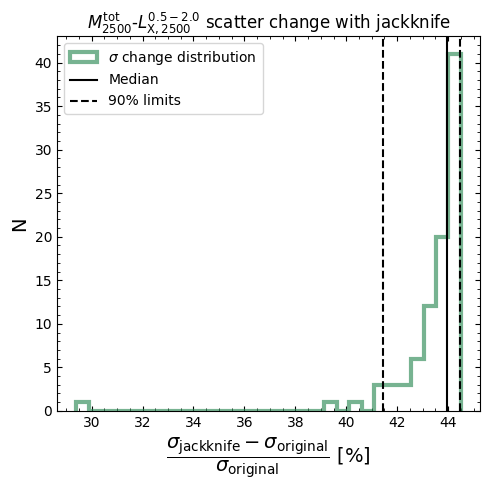

Median percentage change in scatter of 43.96%
90% confidence limits on percentage change in scatter of 41.44% to 44.46%



In [47]:
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

# Plotting the distribution of percentage change in scatter values
plt.hist(l1_mtot2500_lx52_2500_res['scatter_perc_change'].values, bins='auto', color='seagreen', alpha=0.65, 
         label=r"$\sigma$ change distribution", histtype='step', linewidth=3)

# Calculating the median and specified confidence intervals
cur_med = np.median(l1_mtot2500_lx52_2500_res['scatter_perc_change'].values)
cur_low = np.percentile(l1_mtot2500_lx52_2500_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))
cur_upp = np.percentile(l1_mtot2500_lx52_2500_res['scatter_perc_change'].values, (50+(CONF_PERC/2)))

plt.axvline(cur_med, color='black', label='Median')
plt.axvline(cur_low, color='black', linestyle='dashed', label='{}% limits'.format(CONF_PERC))
plt.axvline(cur_upp, color='black', linestyle='dashed')

plt.title(r'$M^{\rm{tot}}_{2500}$-$L^{0.5-2.0}_{\rm{X,2500}}$ scatter change with jackknife')
plt.ylabel('N', fontsize=14)
plt.xlabel(r'$\dfrac{\sigma_{\rm{jackknife}}-\sigma_{\rm{original}}}{\sigma_{\rm{original}}}$ [%]', fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

print("Median percentage change in scatter of {v:.2f}%".format(v=cur_med))
print("{c}% confidence limits on percentage change in scatter of {l:.2f}% to "\
      "{u:.2f}%\n".format(c=CONF_PERC, l=cur_low, u=cur_upp))

#### Selecting 'scatter-dominating' clusters

In [48]:
l1_mtot2500_lx52_2500_domin = l1_mtot2500_lx52_2500_res[l1_mtot2500_lx52_2500_res['scatter_perc_change'] < cur_low]
l1_mtot2500_lx52_2500_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
5,SDSSXCS-11331,0.3954,0.0490,5.2144,0.3205,0.2346,0.0204,41.351
28,SDSSXCS-22,0.4034,0.0453,5.2856,0.3002,0.2147,0.0193,29.396
60,SDSSXCS-5159,0.4051,0.0496,5.0919,0.3130,0.2346,0.0200,41.348
74,SDSSXCS-6955,0.3721,0.0489,5.2199,0.3181,0.2329,0.0201,40.346
82,SDSSXCS-8060,0.4049,0.0488,5.0701,0.3072,0.2311,0.0202,39.257


#### Fitting a new version of the relation without the 'scatter-dominating' clusters

In [49]:
cur_samp_wo_domin = sdssxcs_samp_with_gm2500[~sdssxcs_samp_with_gm2500['name'].isin(l1_mtot2500_lx52_2500_domin['dropped_cluster'].values)]

# Setting up property variables in astropy quantity objects
mtot2500 = Quantity(cur_samp_wo_domin[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')\
    *(cur_samp_wo_domin['E'].values[..., None]**2)
lx2500_52 = Quantity(cur_samp_wo_domin[['Lx52_2500', 'Lx52_2500-','Lx52_2500+']].values, 'erg/s')

mtot2500_lx52_2500_wo_domin = scaling_relation_lira(mtot2500[:, 0], mtot2500[:, 1:], lx2500_52[:, 0], lx2500_52[:, 1:], m_norm, 
                                                     lx_norm, y_name=r"$E(z)^{2}M^{\rm{tot}}_{500}$", 
                                                     x_name=r"$L^{0.5-2.0}_{\rm{X,2500}}$", dim_hubb_ind=2, 
                                                     point_names=cur_samp_wo_domin['name'].values)
mtot2500_lx52_2500_wo_domin.model_colour = 'orchid'
mtot2500_lx52_2500_wo_domin.author = 'Turner et al.'
mtot2500_lx52_2500_wo_domin.year = 2025
mtot2500_lx52_2500_wo_domin.name = r"Turner et al. '$\sigma$ dominating excluded' $E(z)^{2}M^{\rm{tot}}_{2500}$-$L^{0.5-2.0}_{\rm{X,2500}}$"

  |**************************************************| 100%


In [50]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_lx52_2500_wo_domin.pars[0][0], e=mtot2500_lx52_2500_wo_domin.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_lx52_2500_wo_domin.pars[1][0], e=mtot2500_lx52_2500_wo_domin.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_lx52_2500_wo_domin.scatter_par[0], e=mtot2500_lx52_2500_wo_domin.scatter_par[1]))

Slope of 0.452 ± 0.035

Normalisation of 1.770 ± 0.072

Scatter of 0.151 ± 0.013
